In [6]:
!pip install qiskit[visualization]

In [7]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import cplex
    from cplex.exceptions import CplexError
except:
    print("Warning: Cplex not found.")
import math

from qiskit.utils import algorithm_globals
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Sampler

In [8]:
!pip install qiskit-optimization[cplex]

     -------------------------------------- 156.5/156.5 kB 9.1 MB/s eta 0:00:00
     ------------------------------------- 633.5/633.5 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 26.6/26.6 MB 3.2 MB/s eta 0:00:00
  Created wheel for docplex: filename=docplex-2.25.236-py3-none-any.whl size=671402 sha256=5ae40665f3d79140787f69d24b92b06d241fe085a269a53db4f2d151ea556b15
  Stored in directory: c:\users\camila\appdata\local\pip\cache\wheels\1c\d7\f4\e5545af1a1532675110f9ca8c62fc3bfeafc403d2990fea78c
Successfully built docplex


In [9]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import cplex
    from cplex.exceptions import CplexError
except:
    print("Warning: Cplex not found.")
import math

from qiskit.utils import algorithm_globals
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Sampler

In [10]:
# Initialize the problem by defining the parameters
n = 3  # number of nodes + depot (n+1)
K = 2  # number of vehicles

In [11]:
# Get the data
class Initializer:
    def __init__(self, n):
        self.n = n

    def generate_instance(self):

        n = self.n

        # np.random.seed(33)
        np.random.seed(1543)

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
                instance[jj, ii] = instance[ii, jj]

        return xc, yc, instance

In [12]:
# Initialize the problem by randomly generating the instance
initializer = Initializer(n)
xc, yc, instance = initializer.generate_instance()

In [13]:
class ClassicalOptimizer:
    def __init__(self, instance, n, K):

        self.instance = instance
        self.n = n  # number of nodes
        self.K = K  # number of vehicles

    def compute_allowed_combinations(self):
        f = math.factorial
        return f(self.n) / f(self.K) / f(self.n - self.K)

    def cplex_solution(self):

        # refactoring
        instance = self.instance
        n = self.n
        K = self.K

        my_obj = list(instance.reshape(1, n**2)[0]) + [0.0 for x in range(0, n - 1)]
        my_ub = [1 for x in range(0, n**2 + n - 1)]
        my_lb = [0 for x in range(0, n**2)] + [0.1 for x in range(0, n - 1)]
        my_ctype = "".join(["I" for x in range(0, n**2)]) + "".join(
            ["C" for x in range(0, n - 1)]
        )

        my_rhs = (
            2 * ([K] + [1 for x in range(0, n - 1)])
            + [1 - 0.1 for x in range(0, (n - 1) ** 2 - (n - 1))]
            + [0 for x in range(0, n)]
        )
        my_sense = (
            "".join(["E" for x in range(0, 2 * n)])
            + "".join(["L" for x in range(0, (n - 1) ** 2 - (n - 1))])
            + "".join(["E" for x in range(0, n)])
        )

        try:
            my_prob = cplex.Cplex()
            self.populatebyrow(my_prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs)

            my_prob.solve()

        except CplexError as exc:
            print(exc)
            return

        x = my_prob.solution.get_values()
        x = np.array(x)
        cost = my_prob.solution.get_objective_value()

        return x, cost

    def populatebyrow(self, prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs):

        n = self.n

        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj=my_obj, lb=my_lb, ub=my_ub, types=my_ctype)

        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        rows = []
        for ii in range(0, n):
            col = [x for x in range(0 + n * ii, n + n * ii)]
            coef = [1 for x in range(0, n)]
            rows.append([col, coef])

        for ii in range(0, n):
            col = [x for x in range(0 + ii, n**2, n)]
            coef = [1 for x in range(0, n)]

            rows.append([col, coef])

        # Sub-tour elimination constraints:
        for ii in range(0, n):
            for jj in range(0, n):
                if (ii != jj) and (ii * jj > 0):

                    col = [ii + (jj * n), n**2 + ii - 1, n**2 + jj - 1]
                    coef = [1, 1, -1]

                    rows.append([col, coef])

        for ii in range(0, n):
            col = [(ii) * (n + 1)]
            coef = [1]
            rows.append([col, coef])

        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)

In [14]:
# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(instance, n, K)

# Print number of feasible solutions
print("Number of feasible solutions = " + str(classical_optimizer.compute_allowed_combinations()))

Number of feasible solutions = 3.0


In [15]:
# Solve the problem in a classical fashion via CPLEX
x = None
z = None
try:
    x, classical_cost = classical_optimizer.cplex_solution()
    # Put the solution in the z variable
    z = [x[ii] for ii in range(n**2) if ii // n != ii % n]
    # Print the solution
    print(z)
except:
    print("CPLEX may be missing.")

[1.0, 1.0, 1.0, 0.0, 1.0, 0.0]


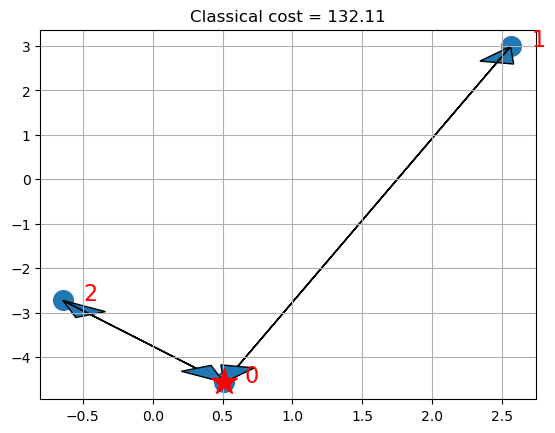

In [16]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color="r")
    plt.plot(xc[0], yc[0], "r*", ms=20)

    plt.grid()

    for ii in range(0, n**2):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(
                xc[ix],
                yc[ix],
                xc[iy] - xc[ix],
                yc[iy] - yc[ix],
                length_includes_head=True,
                head_width=0.25,
            )

    plt.title(title_str + " cost = " + str(int(C * 100) / 100.0))
    plt.show()


if x is not None:
    visualize_solution(xc, yc, x, classical_cost, n, K, "Classical")